In [1]:
import pandas
from IPython.display import *
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats
import numpy as np
from praveganb.idracdemo import *
from praveganb.idracdemo import IdracData as VsphereData
import seaborn as sns
%matplotlib inline

# Setup the Connection with pravega

In [2]:
vspheredata = VsphereData(scope='vsphere', stream='vmware', gateway='10.243.37.84:80')

In [4]:
stream_info = vspheredata.get_stream_start_end()

KeyboardInterrupt: 

# Read data from Stream

In [4]:
metrics = vspheredata.get_metric_from_vsphere(stream_info[0])
vsphere = "vcenter.anchorsteam.local"
metric_label = 'vsphere_host_mem'
results = []
dfs = pandas.DataFrame()
for _metric in metrics:
    results.extend([metric for metric in _metric['metrics'] if metric['name'] == metric_label])

KeyboardInterrupt: 

# Using dataframe, Setup the Index

In [5]:
dfs = pandas.DataFrame()
dfs = dfs.append(pandas.json_normalize(results))
dfs['timestamp'] = pandas.to_datetime(dfs['timestamp'], unit='s')
dfs.set_index('timestamp', inplace=True)

# Keep all records on compute nodes

In [7]:
data_to_analyse = dfs.loc[(dfs['tags.vcenter'] == vsphere) & (dfs['tags.clustername'] == 'compute'), ['fields.usage_average', 'tags.source', 'tags.vcenter', 'tags.clustername']]
display(data_to_analyse.tail())

,fields.usage_average,tags.source,tags.vcenter,tags.clustername
timestamp,,,,
2020-04-24 19:37:00,75.656667,10.243.86.38,vcenter.anchorsteam.local,compute
2020-04-24 19:37:00,86.426667,10.243.86.40,vcenter.anchorsteam.local,compute
2020-04-24 19:37:00,76.033333,10.243.86.32,vcenter.anchorsteam.local,compute
2020-04-24 19:37:00,74.436667,10.243.86.34,vcenter.anchorsteam.local,compute
2020-04-24 19:37:00,76.436667,10.243.86.36,vcenter.anchorsteam.local,compute
...,...,...,...,...
2020-04-27 22:01:00,82.130000,10.243.86.32,vcenter.anchorsteam.local,compute
2020-04-27 22:01:00,80.480000,10.243.86.34,vcenter.anchorsteam.local,compute
2020-04-27 22:00:00,80.505000,10.243.86.34,vcenter.anchorsteam.local,compute


# Calculate Standard deviation from the collected data

In [8]:
stdv = data_to_analyse['fields.usage_average'].std()
mean = data_to_analyse['fields.usage_average'].mean()
count = data_to_analyse['fields.usage_average'].count()
stdv, mean

(3.7712361966440775, 80.10322494864612)

# Using gaussian distribution(survival function) to calculate the probability of >80% usage

In [ ]:
grsf = norm.sf(x=usage, loc=mean, scale=stdv) * 100
print('{0}%'.format(grsf))

# Plot The results using Bell curve(Normal distribution)

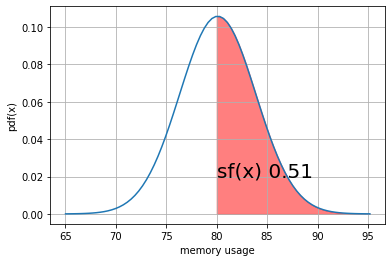

In [13]:
fig, ax = plt.subplots()
x = np.linspace(mean-4*stdv,mean+4*stdv, int(mean))
p = norm.pdf(x, scale=stdv, loc=mean) 
ax.plot(x, norm.pdf(x, scale=stdv, loc=mean), label='stdv=%.1f' % stdv)
ax.set_xlabel('memory usage')
ax.set_ylabel('pdf(x)')
ax.grid(True)
px=np.arange(usage, mean+4*stdv, 0.01)
ax.fill_between(px,norm.pdf(px,scale=stdv, loc=mean),alpha=0.5, color='r')
ax.text(usage,0.02,"sf(x) %.2f" %(grsf), fontsize=20)
plt.show()